In [1]:
import warnings
from collections import Counter
from typing import Callable, Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(16,8)})
import scipy
from imblearn.over_sampling import RandomOverSampler
from sklearn import metrics, tree
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from metrics_eo import equailized_odds
from objective import Objective
from reprojections import reproject_features_w_regul, reproject_features
from study_reprojection import data_preprocessing

import utils

In [2]:
standardize = True
standardize_continuous = True
resample = False
reproject = False
lambda_reproject = False
run_optim_no_fairness = False

train = pd.read_csv('data/heart_train.csv')
val = pd.read_csv('data/heart_val.csv')
test = pd.read_csv('data/heart_test.csv')

# Select only rows with black and white race
train = train.loc[train['Race'].isin(['White', 'Black'])]
val = val.loc[val['Race'].isin(['White', 'Black'])]
test = test.loc[test['Race'].isin(['White', 'Black'])]

categorical_features = [
    "Smoking",
    "AlcoholDrinking",
    "Stroke",
    "DiffWalking",
    "Sex",
    "AgeCategory",
    "Race",
    "Diabetic",
    "PhysicalActivity",
    "GenHealth",
    "Asthma",
    "KidneyDisease",
    "SkinCancer"
]

continuos_features = [
    "BMI",
    "PhysicalHealth",
    "MentalHealth"
]

target_variable = "HeartDisease"

train_processed, train_original, train_target, train_race = data_preprocessing(
    train, categorical_features=categorical_features,
    continuos_features=continuos_features,
    target_variable=target_variable)
val_processed, val_original, val_target, val_race = data_preprocessing(
    val, categorical_features=categorical_features,
    continuos_features=continuos_features,
    target_variable=target_variable)
test_processed, test_original, test_target, test_race = data_preprocessing(
    test, categorical_features=categorical_features,
    continuos_features=continuos_features,
    target_variable=target_variable)

y_train, y_val, y_test = train_target, val_target, test_target

if standardize:
    if standardize_continuous:
        # Scale continuous variables
        mean_ = np.mean(train_processed[continuos_features], axis=0)
        std_ = np.std(train_processed[continuos_features], ddof=1, axis=0)

        train_processed = (
            train_processed[continuos_features] - mean_) / std_
        val_processed = (val_processed[continuos_features] - mean_) / std_
        test_processed = (
            test_processed[continuos_features] - mean_) / std_

    else:
        # Standardize all variables
        mean_ = np.mean(train_processed, axis=0)
        std_ = np.std(train_processed, ddof=1, axis=0)

        train_processed = (train_processed - mean_) / std_
        val_processed = (val_processed - mean_) / std_
        test_processed = (test_processed - mean_) / std_

sampler = optuna.samplers.TPESampler()

# Do random oversampling to make class distribution even
if resample:
    ros = RandomOverSampler(random_state=42)
    train_processed, y_train, = ros.fit_resample(
        train_processed, y_train)

best_params_exp1 = {'criterion': 'gini', 'max_depth': 47, 'min_samples_split': 0.0004022470062251528, 'min_samples_leaf': 6.222809365932753e-05}
best_params_exp2 = {'criterion': 'gini', 'max_depth': 46, 'min_samples_split': 0.0031163168319514006, 'min_samples_leaf': 0.002909135794829023}

model = DecisionTreeClassifier(**best_params_exp1)
model.fit(train_processed, y_train)

val_pred = model.predict(val_processed)
val_pred_proba = model.predict_proba(val_processed)
test_pred = model.predict(test_processed)
test_pred_proba = model.predict_proba(test_processed)

In [3]:
def map_array(arr:np.ndarray):
    d = {"No":0, "Yes":1}
    
    return np.array(list(map(lambda x: d[x], arr)))

In [4]:
val_target = map_array(val_target)
val_pred = map_array(val_pred)

In [5]:
test_target = map_array(test_target)
test_pred = map_array(test_pred)

In [6]:
def evaluate(y_target, y_pred, y_race):
    print(classification_report(y_target, y_pred))
    print(utils.classification_report(y_target, y_pred, y_race))
    print(confusion_matrix(y_target, y_pred, normalize='true', labels=[1,0]))

In [7]:
def equalized_odds(preds, groups, test):
    df = pd.DataFrame(list(zip(preds, groups, test)), columns=['preds', 'groups', 'test'])
    targets = df['test'].unique()
    groups = df['groups'].unique()
    labels = []
    y = []
    
    
    for target in targets:
        temp_labels = []
        temp_y = []
        for group in groups:
            selection = df.loc[(df['test'] == target) & (df['groups'] == group)]
            corrects = selection.loc[selection['preds'] == target]
            score = round(len(corrects) / len(selection), 3) #how many correct out of all for this target and group
            temp_labels.append(f'T: {target}, G: {group}')
            temp_y.append(score)
        labels.append(temp_labels)
        y.append(temp_y)
    

    
    # PLOTTING
    fig, ax = plt.subplots(figsize=(6,5), sharey=True)
    
    x = np.arange(len(groups))  # the label locations
    x = np.array([i*2 for i in x])
    width = 0.5
    
    rects1 = ax.bar(x - width/2, y[0], width, label='No') #0
    rects2 = ax.bar(x + width/2, y[1], width, label='Yes') #1
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Score')
    ax.set_title('Scores by group and target')
    ax.set_xticks(x, groups)
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    plt.tight_layout()
    plt.show()

In [8]:
def find_thresholds(parameters, i, fpr_goal=0.6):
    threshold = parameters["threshold"][i]
    fpr = parameters["fpr"][i]
    
    idx = np.argmin(abs(fpr_goal - parameters["fpr"][i]))
    threshold = parameters["threshold"][i][idx]
    
    return threshold, idx


def plot_roc_curve(y_race:np.ndarray, y_target:np.ndarray, y_pred_proba:np.ndarray):
    fig, ax = plt.subplots(figsize=(6,6))
    parameters = {"fpr": [], "tpr": [], "threshold": []}

    for race in np.unique(y_race):
        y_score = y_pred_proba[y_race==race]
        fpr, tpr, threshold = roc_curve(y_target[y_race==race], y_score[:, 1], drop_intermediate=False)
        roc_auc = auc(fpr, tpr)

        ax.plot(
            fpr,
            tpr,
            lw=1,
            label=f"ROC curve {race} (area = %0.2f)" % roc_auc)
        parameters["fpr"].append(fpr)
        parameters["tpr"].append(tpr)
        parameters["threshold"].append(threshold)
    plt.xlabel('fpr', fontsize=12)
    plt.ylabel('tpr', fontsize=12, rotation=0)
    
    return fig, ax, parameters

In [9]:
def recalculate_predictions(val_race, val_pred_proba, white_threshold, black_threshold):
    # Re-calculate predictions using new thresholds

    y_pred_fair = list()
    for race, proba in zip(val_race, val_pred_proba[:,1]):
        if race == "White":
            y_pred_fair.append(1 if proba >= white_threshold else 0)
        elif race == "Black":
            y_pred_fair.append(1 if proba >= black_threshold else 0)
    y_pred_fair = np.array(y_pred_fair)
    
    return y_pred_fair

# Experiment 1
### Validation

In [10]:
evaluate(val_target, val_pred, val_race)

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     36506
           1       0.42      0.01      0.02      3609

    accuracy                           0.91     40115
   macro avg       0.67      0.50      0.48     40115
weighted avg       0.87      0.91      0.87     40115

A                              TPR   FPR   TNR   FNR  
------------------------------------------------------
Black                          0.01  0.00  1.00  1.00 
White                          0.01  0.00  1.00  1.00 
All                            0.01  0.00  1.00  1.00 
[[0.00858964 0.99141036]
 [0.0011505  0.9988495 ]]


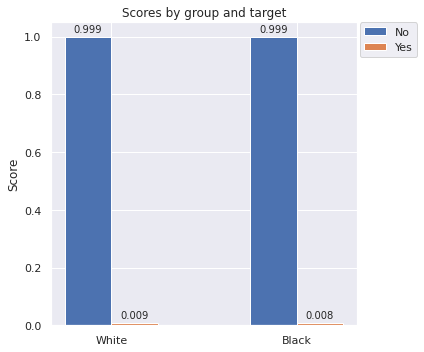

In [11]:
equalized_odds(val_pred, val_race, val_target)

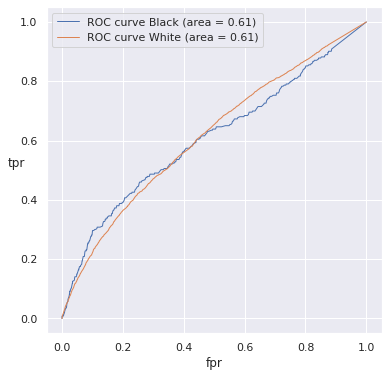

In [12]:
fig, ax, parameters = plot_roc_curve(val_race, val_target, val_pred_proba)
plt.legend()

In [13]:
fpr_goal = 0.4
threshold_black, idx_b = find_thresholds(parameters, 0, fpr_goal) #0=black
threshold_White, idx_w = find_thresholds(parameters, 1, fpr_goal) #1=white
threshold_black, threshold_White

(0.08571428571428572, 0.08163265306122448)

In [14]:
parameters["fpr"][0][idx_b], parameters["fpr"][1][idx_w]

(0.4008922880815806, 0.40296092064253175)

In [15]:
parameters["threshold"][0][idx_b], parameters["threshold"][1][idx_w]

(0.08571428571428572, 0.08163265306122448)

In [16]:
p1 = parameters["fpr"][0][idx_b], parameters["tpr"][0][idx_b]
p1

(0.4008922880815806, 0.5627376425855514)

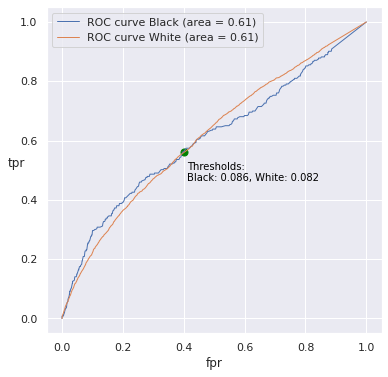

In [17]:
ax.scatter(p1[0], p1[1], s=50, color = 'green')
ax.annotate(text = f'Thresholds:\nBlack: {round(threshold_black, 3)}, White: {round(threshold_White, 3)}', xy = (p1[0]+0.01, p1[1]-0.1), size=10, color = 'black')
fig

In [18]:
val_pred_fair = recalculate_predictions(val_race, val_pred_proba, threshold_White, threshold_black)

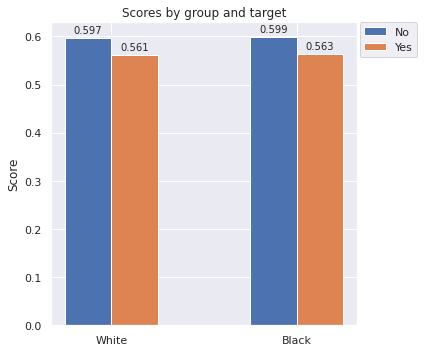

In [19]:
equalized_odds(val_pred_fair, val_race, val_target)

In [20]:
evaluate(val_target, val_pred_fair, val_race)

              precision    recall  f1-score   support

           0       0.93      0.60      0.73     36506
           1       0.12      0.56      0.20      3609

    accuracy                           0.59     40115
   macro avg       0.53      0.58      0.46     40115
weighted avg       0.86      0.59      0.68     40115

A                              TPR   FPR   TNR   FNR  
------------------------------------------------------
Black                          0.56  0.40  1.00  1.00 
White                          0.56  0.40  1.00  1.00 
All                            0.56  0.40  1.00  1.00 
[[0.56137434 0.43862566]
 [0.4027831  0.5972169 ]]


### Test

In [21]:
evaluate(test_target, test_pred, test_race)

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     36590
           1       0.13      0.00      0.00      3643

    accuracy                           0.91     40233
   macro avg       0.52      0.50      0.48     40233
weighted avg       0.84      0.91      0.87     40233

A                              TPR   FPR   TNR   FNR  
------------------------------------------------------
Black                          0.01  0.00  1.00  1.00 
White                          0.00  0.00  1.00  1.00 
All                            0.00  0.00  1.00  1.00 
[[0.00219599 0.99780401]
 [0.00142115 0.99857885]]


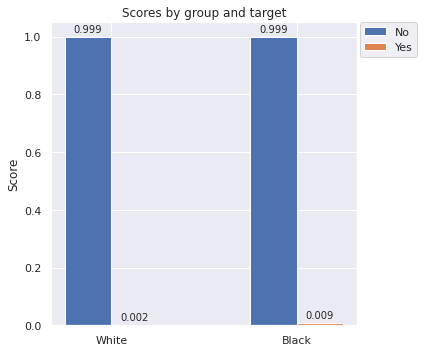

In [22]:
equalized_odds(test_pred, test_race, test_target)

In [23]:
test_pred_fair = recalculate_predictions(test_race, test_pred_proba, threshold_White, threshold_black)

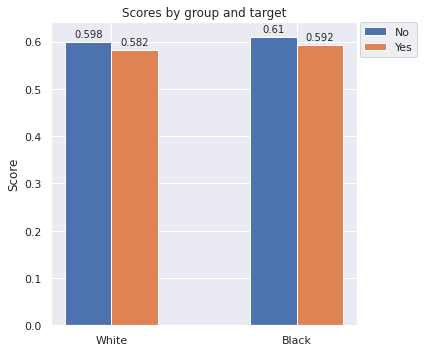

In [25]:
equalized_odds(test_pred_fair, test_race, test_target)

In [24]:
evaluate(test_target, test_pred_fair, test_race)

              precision    recall  f1-score   support

           0       0.94      0.60      0.73     36590
           1       0.13      0.58      0.21      3643

    accuracy                           0.60     40233
   macro avg       0.53      0.59      0.47     40233
weighted avg       0.86      0.60      0.68     40233

A                              TPR   FPR   TNR   FNR  
------------------------------------------------------
Black                          0.59  0.39  1.00  0.99 
White                          0.58  0.40  1.00  1.00 
All                            0.58  0.40  1.00  1.00 
[[0.58303596 0.41696404]
 [0.40131183 0.59868817]]


### Explainability 

In [28]:
model.feature_importances_

array([0.50156195, 0.40250091, 0.09593715])

In [30]:
model.feature_names_in_

array(['BMI', 'PhysicalHealth', 'MentalHealth'], dtype=object)

# Experiment 2
### Validation

In [25]:
evaluate(val_target, val_pred, val_race)

              precision    recall  f1-score   support

           0       0.94      0.69      0.79     36506
           1       0.14      0.53      0.22      3609

    accuracy                           0.67     40115
   macro avg       0.54      0.61      0.51     40115
weighted avg       0.86      0.67      0.74     40115

A                              TPR   FPR  
------------------------------------------
Black                          0.56  0.37 
White                          0.52  0.31 
All                            0.53  0.31 
[[0.52673871 0.47326129]
 [0.31446885 0.68553115]]


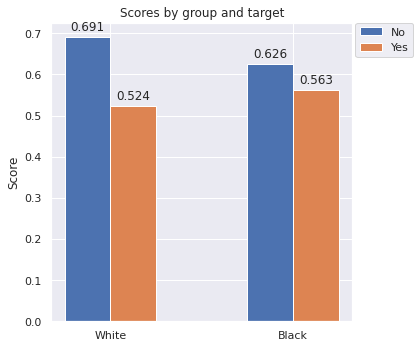

In [179]:
equalized_odds(val_pred, val_race, val_target)

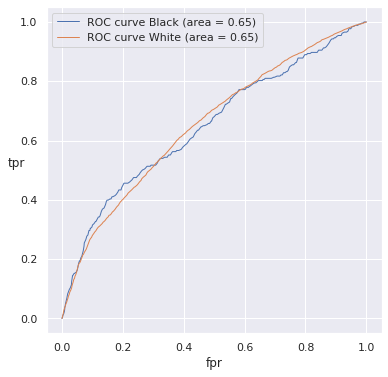

In [146]:
fig, ax, parameters = plot_roc_curve(val_race, val_target, val_pred_proba)
plt.legend()

    Based on the roc curve we choose the cutpoint to be the intersection at fpr=0.6

In [147]:
fpr_goal = 0.6
threshold_black, idx_b = find_thresholds(parameters, 0, fpr_goal) #0=black
threshold_White, idx_w = find_thresholds(parameters, 1, fpr_goal) #1=white
threshold_black, threshold_White

(0.4351005484460695, 0.4143070044709389)

In [148]:
np.argmin(abs(fpr_goal - parameters["fpr"][0]))

155

In [149]:
p1 = parameters["fpr"][0][idx_b], parameters["tpr"][0][idx_b]
p1

(0.6013384321223709, 0.7718631178707225)

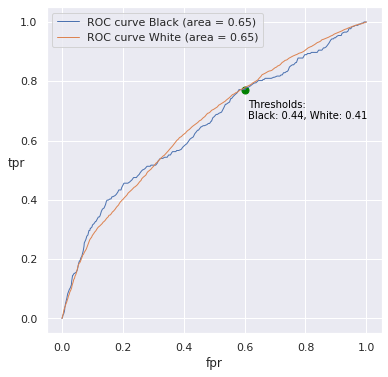

In [150]:
ax.scatter(p1[0], p1[1], s=50, color = 'green')
ax.annotate(text = f'Thresholds:\nBlack: {round(threshold_black, 2)}, White: {round(threshold_White, 2)}', xy = (p1[0]+0.01, p1[1]-0.1), size=10, color = 'black')
fig

In [163]:
val_pred_fair = recalculate_predictions(val_race, val_pred_proba, threshold_White, threshold_black)

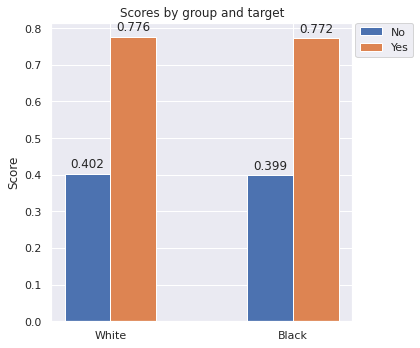

In [164]:
equalized_odds(val_pred_fair, val_race, val_target)

In [165]:
evaluate(val_target, val_pred_fair, val_race)

              precision    recall  f1-score   support

           0       0.95      0.40      0.56     36506
           1       0.11      0.78      0.20      3609

    accuracy                           0.44     40115
   macro avg       0.53      0.59      0.38     40115
weighted avg       0.87      0.44      0.53     40115

A                              TPR   FPR  
------------------------------------------
Black                          0.77  0.60 
White                          0.78  0.60 
All                            0.78  0.60 
[[0.7755611  0.2244389 ]
 [0.59855914 0.40144086]]


### Test set

In [166]:
evaluate(test_target, test_pred, test_race)

              precision    recall  f1-score   support

           0       0.94      0.68      0.79     36590
           1       0.14      0.53      0.23      3643

    accuracy                           0.67     40233
   macro avg       0.54      0.61      0.51     40233
weighted avg       0.86      0.67      0.74     40233

A                              TPR   FPR  
------------------------------------------
Black                          0.57  0.36 
White                          0.53  0.31 
All                            0.53  0.32 
[[0.53143014 0.46856986]
 [0.31688986 0.68311014]]


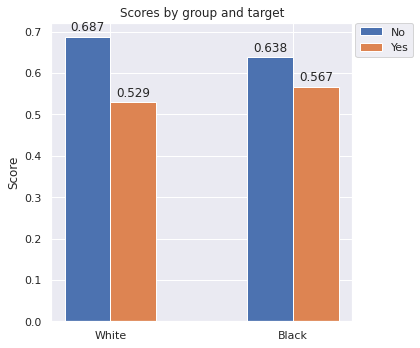

In [167]:
equalized_odds(test_pred, test_race, test_target)

In [168]:
test_pred_fair = recalculate_predictions(test_race, test_pred_proba, threshold_White, threshold_black)

In [169]:
evaluate(test_target, test_pred_fair, test_race)

              precision    recall  f1-score   support

           0       0.95      0.40      0.56     36590
           1       0.11      0.78      0.20      3643

    accuracy                           0.43     40233
   macro avg       0.53      0.59      0.38     40233
weighted avg       0.87      0.43      0.53     40233

A                              TPR   FPR  
------------------------------------------
Black                          0.73  0.57 
White                          0.78  0.60 
All                            0.78  0.60 
[[0.77655778 0.22344222]
 [0.59923476 0.40076524]]
